In [4]:
%matplotlib inline
path = "data/kaggle/dogscats/"
import utils; reload(utils)
from utils import *
import keras

# Explore

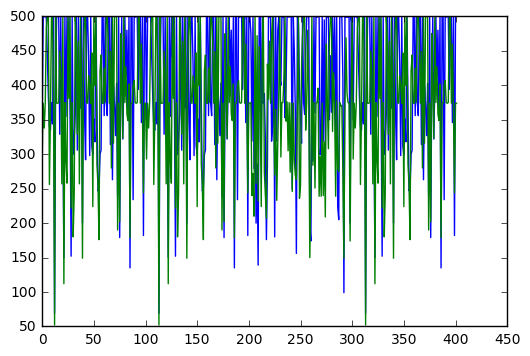

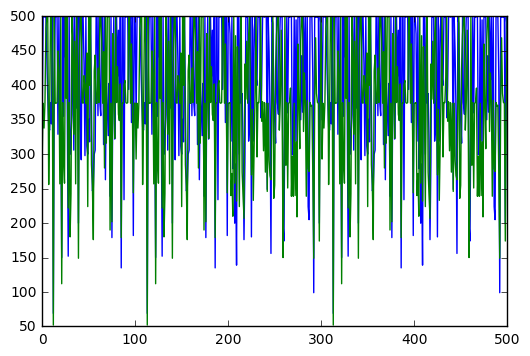

Dogs(mean,std)=(array([ 399.3507,  374.5622]), array([ 107.4896,  100.5482])), 
Cats(Mean,Std)=(array([ 400.6467,  370.3812]), array([ 108.2237,   99.597 ]))


In [33]:
#Understand the dimensions of the images
def getMeanStdOfImages():
    for file in glob("*.jpg"):
        img = Image.open(file)
        img_sizes.append(img.size)            
    plt.plot(img_sizes)
    plt.show()
    mean = np.mean(img_sizes,axis=0)
    std = np.std(img_sizes,axis=0)
    return mean,std    

#os.chdir("data/kaggle/dogscats/sample/train/cat")
os.chdir("../dog")
dogsStats = getMeanStdOfImages()
os.chdir("../cat")
catsStats = getMeanStdOfImages()
print 'Dogs(mean,std)={}, \nCats(Mean,Std)={}'.format(dogsStats,catsStats)


In [3]:
#Look at the dimensions of one image
#RGB or Grey scale?
img = Image.open(path+'train/cat/cat.10478.jpg')
img.size
arr = np.array(img)
arr.shape

(375, 475, 3)

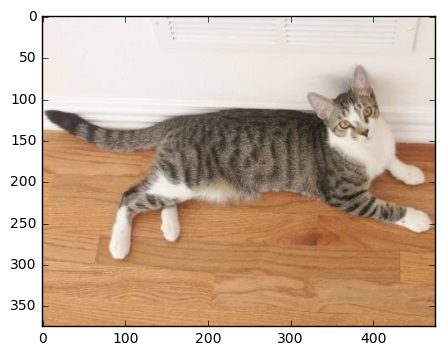

In [4]:
#Plot some images at random
imgplot = plt.imshow(img)

# Model

In [6]:
batch_size=64

In [4]:
from vgg16 import Vgg16
vgg = Vgg16()

In [5]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.ft(batches.nb_class)

NameError: name 'batch_size' is not defined

In [92]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
200/200 [==============================] - 7s - loss: 4.0563 - acc: 0.6100 - val_loss: 2.5789 - val_acc: 0.8400


In [7]:
vgg.model.save_weights(path+'results/10EpochsVGG.h5')

# Add batch normalization

In [4]:
from vgg16bn import Vgg16BN
vgg = Vgg16BN()


In [8]:
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
vgg.ft(batches.nb_class)

In [10]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 653s - loss: 0.2241 - acc: 0.9554 - val_loss: 0.1018 - val_acc: 0.9785


In [3]:
model = vgg_ft_bn(2)
model.summary()
model.compile()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [ ]:
model.fit_generator(batches, )

In [34]:
#Separate Conv and FC models
last_conv_idx = [index for index,layer in enumerate(vgg.model.layers) 
                     if type(layer) is Convolution2D][-1]
conv_layers = vgg.model.layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)

In [29]:
fc_layers = vgg.model.layers[last_conv_idx+1:]
#len(fc_layers)

7

In [38]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(p),
        BatchNormalization(axis=1),
        Dense(4096, activation='relu'),
        Dropout(p),
        BatchNormalization(axis=1),
        Dense(1000, activation='softmax')
        ]

In [39]:
bn_model = Sequential(get_bn_layers(0.6))
conv_model.add(bn_model)

Exception: You are attempting to share a same `BatchNormalization` layer across different data flows. This is not possible. You should use `mode=2` in `BatchNormalization`, which has a similar behavior but is shareable (see docs for a description of the behavior).

In [32]:
bn_model.load_weights('/home/ubuntu/nbs/data/kaggle/dogscats/results/vgg16_bn.h5')

Exception: You are trying to load a weight file containing 18 layers into a model with 5 layers.

In [ ]:
#Ran 2 more epochs and saved weights
vgg.fit(batches, val_batches, nb_epoch=2)

In [ ]:
vgg.model.save_weights(path+'results/vgg3.h5')

In [60]:
#Using Adam optimizer with 0.001 lr
vgg.model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])


In [ ]:
vgg.fit(batches, val_batches, nb_epoch=1)

In [ ]:
vgg.model.save_weights(path+'results/vgg4.h5')

In [ ]:
vgg.model.compile(Nadam(), 'categorical_crossentropy', metrics=['accuracy'])
vgg.fit(batches, val_batches, nb_epoch=1)

In [99]:
#Data augmentation
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True, channel_shift_range=0.1)
batches = get_batches(path+'train', gen, batch_size=batch_size)
#vgg.fit(batches, val_batches, nb_epoch=1)

Found 23000 images belonging to 2 classes.


In [14]:
vgg.model.save_weights(path+'results/vgg5.h5')

In [65]:
batches.shape()

AttributeError: 'DirectoryIterator' object has no attribute 'shape'

In [8]:
vgg.model.load_weights(path+'results/10EpochsVGG.h5')

# Modify model

In [6]:
vgg.model.load_weights(path+'results/adam4.h5')

In [13]:
import pickle
def saveResults(handle, result):
    f = open(path + 'results/' + handle + '.result', 'wb')
    pickle.dump(result, f)
    f.close()

In [17]:
result = vgg.fit(batches, val_batches, nb_epoch=1)


Epoch 1/1
200/200 [==============================] - 7s - loss: 0.8715 - acc: 0.9450 - val_loss: 0.3224 - val_acc: 0.9800
Epoch 1/1
200/200 [==============================] - 7s - loss: 0.8141 - acc: 0.9450 - val_loss: 0.3224 - val_acc: 0.9800


In [16]:
print result

None


In [14]:
saveResults('test', result)

In [66]:
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [81]:
# Ensure that we return to theano dimension ordering
K.set_image_dim_ordering('th')

In [100]:
batches = get_batches(path+'train', gen, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(path+'valid', shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
vgg.model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam1.h5')
vgg.model.optimizer.lr=0.0001
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam2.h5')
vgg.fit(batches, val_batches, nb_epoch=2)
vgg.model.save_weights(path+'results/adam3.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam4.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam5.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam6.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam7.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam8.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam9.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam10.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam11.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam12.h5')
vgg.model.optimizer.lr=0.001
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam13.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam14.h5')
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path+'results/adam15.h5')

Epoch 1/1
 4352/23000 [====>.........................] - ETA: 456s - loss: 0.6138 - acc: 0.9612

In [ ]:
## Remove drop outs
def noDropOutModel():
    

# Test

In [15]:
#Test on test data
test_batches, preds = vgg.test(path+'test', batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


# Generate Kaggle submission

In [43]:
#Generatae submission = fileNumber, prediction
#test_batches.filenames[:5]
#Generate ids
ids = [int(f[8:f.find('.')]) for f in test_batches.filenames]

In [40]:
#ids[:5]
#preds[0:5]

[9292, 12026, 9688, 4392, 779]

In [44]:
#Generate predictions
isdog = np.clip(preds[:,1], 0.01, 0.99)
isdog[:5]

array([ 0.01  ,  0.7047,  0.01  ,  0.01  ,  0.99  ], dtype=float32)

In [45]:
#join them row by row(axis =1)
subm = np.stack([ids,isdog], axis=1)

In [46]:
np.set_printoptions(suppress=True)
subm[:5]

array([[  9292.    ,      0.01  ],
       [ 12026.    ,      0.7047],
       [  9688.    ,      0.01  ],
       [  4392.    ,      0.01  ],
       [   779.    ,      0.99  ]])

In [47]:
np.savetxt('resnet_ga.csv', subm, fmt='%d,%.3f', header='id,label', comments='')
from IPython.display import FileLink
FileLink('resnet_ga.csv')

/home/ubuntu/nbs/resnet_ga.csv

# Explore predictions

In [45]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  0           zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [48]:
vgg.model.load_weights(path+'results/vgg5.h5')

In [8]:
#Explore the images which we were confident but got them wrong
val_batches, probs = vgg.test(path+'valid', batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [9]:
probs = probs[:,0]
preds = np.round(1-probs)

## How are probabilities distributed?

In [9]:
probs[:4]

array([ 1.,  1.,  1.,  1.], dtype=float32)

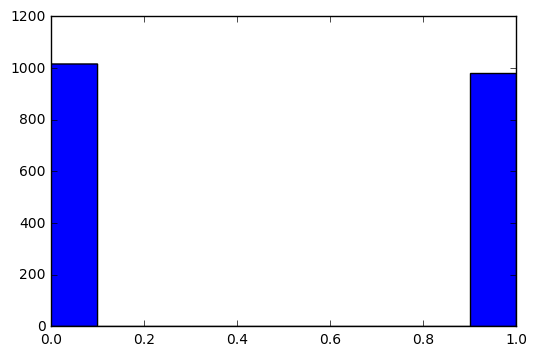

In [10]:
(n, bins, patches) = plt.hist(probs)
plt.show()

In [11]:
np.set_printoptions(suppress=True)
print n

[ 1020.     0.     0.     0.     0.     0.     0.     0.     0.   980.]


## Confusion matrix

In [11]:
cm = confusion_matrix(val_batches.classes,preds)

[[971  27]
 [ 13 989]]


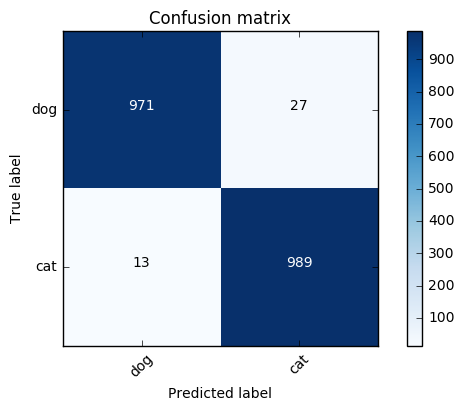

In [12]:
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

In [18]:
val_batches.filenames[:5]

['cat/cat.1101.jpg',
 'cat/cat.9976.jpg',
 'cat/cat.2421.jpg',
 'cat/cat.1646.jpg',
 'cat/cat.7859.jpg']

In [13]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + val_batches.filenames[i]) for i in idx], titles=titles)

## Find images which have been predicted wrong with highest confidence

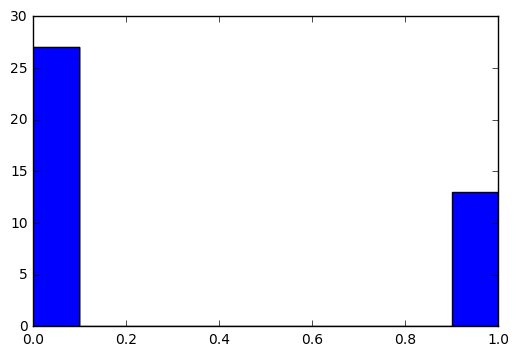

In [14]:
labels = val_batches.classes
mismatch_idx = np.where((preds!=labels))[0]
mismatch_probs = probs[mismatch_idx]
(n, bins, patches) = plt.hist(mismatch_probs)
plt.show()

In [59]:
mismatch_idx.size

90

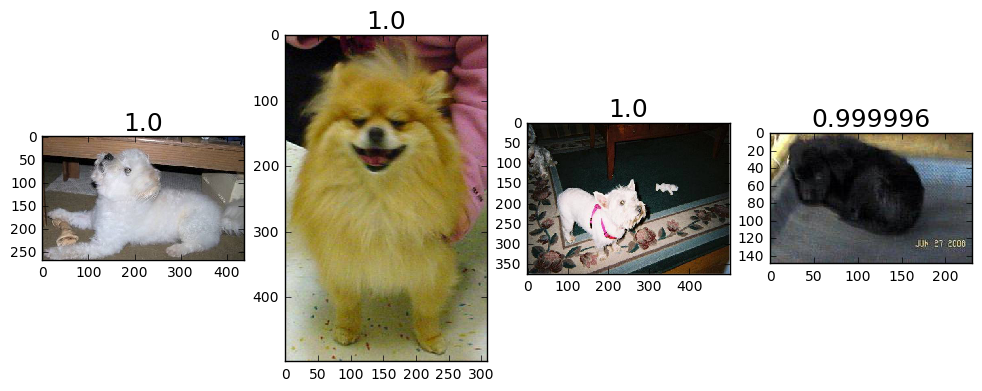

In [55]:
incorrect_cats = np.where((preds==0) &(preds!=labels))[0]
#incorrect_cats.size
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][8:12]
most_incorrect_cats
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])

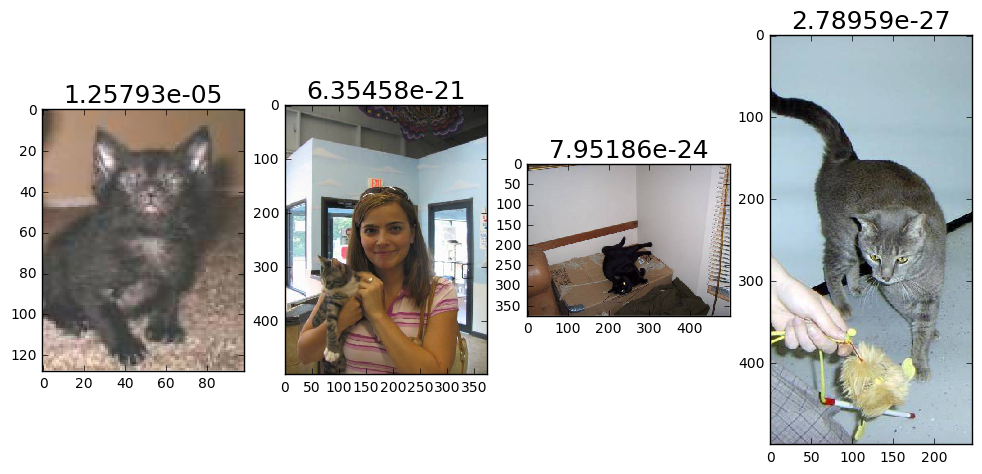

In [56]:
incorrect_dogs = np.where((preds==1) &(preds!=labels))[0]
#incorrect_cats.size
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[::-1][:4]
#most_incorrect_cats
plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs])

In [57]:
#pred!=labels && 
#class=0 and prob[0] is highest: Dogs but predicted as cats
#val_batches.classes == 0
#predicted_cats = val_batches[val_batches.classes == 0]
n_view =4
labels = val_batches.classes
incorrect_cats = np.where((preds==0) & (preds!=labels))[0]
most_incorrect_cats = np.argsort(probs2[incorrect_cats])[::-1][:4]
most_incorrect_cats
plots_idx(incorrect_cats[most_incorrect_cats], probs2[incorrect_cats][most_incorrect_cats])
#class=1 and prob[0] is lowest


NameError: name 'probs2' is not defined

## Batch normalization


In [4]:
from vgg16bn import Vgg16BN
vgg = Vgg16BN()
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.ft(batches.nb_class)
vgg.model.save_weights("results/weights-improvement-14-0.98.hdf5")

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
#Test on test data
test_batches, preds = vgg.test(path+'test', batch_size = batch_size*2)

Found 12500 images belonging to 1 classes.


In [6]:
ids = [int(f[8:f.find('.')]) for f in test_batches.filenames]
isdog = np.clip(preds[:,1], 0.01, 0.99)
subm = np.stack([ids,isdog], axis=1)
np.set_printoptions(suppress=True)
subm[:5]

array([[  9292.    ,      0.2768],
       [ 12026.    ,      0.0996],
       [  9688.    ,      0.01  ],
       [  4392.    ,      0.7749],
       [   779.    ,      0.99  ]])

In [7]:
np.savetxt(path + 'results/cats_bn.csv', subm, fmt='%d,%.3f', header='id,label', comments='')
from IPython.display import FileLink
FileLink(path + 'results/cats_bn.csv')

/home/ubuntu/nbs/cats_bn.csv

In [8]:
FileLink(path + 'results/cats_bn.csv')

/home/ubuntu/nbs/data/kaggle/dogscats/results/cats_bn.csv

## Trying Resnet

In [2]:
from resnet50 import Resnet50
rs_model = Resnet50(include_top=False)

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [34]:
rs_model.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 3, 224, 224)   0           input_1[0][0]                    
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 230, 230)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 112, 112)  9472        zeropadding2d_1[0][0]            
___________________________________________________________________________________________

In [7]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)
test_batches = get_batches(path+'test', batch_size=batch_size*2, shuffle=False)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [35]:
batches = get_batches(path+'train', batch_size=batch_size, shuffle=False)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)
test_batches = get_batches(path+'test', batch_size=batch_size*2, shuffle=False)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [36]:
trn_features = rs_model.model.predict_generator(batches, batches.nb_sample)

In [37]:
val_features = rs_model.model.predict_generator(val_batches, val_batches.nb_sample)
test_features = rs_model.model.predict_generator(test_batches, test_batches.nb_sample)

In [38]:
save_array(path+'results/trn_features.dat', trn_features)
save_array(path+'results/val_features.dat', val_features)
save_array(path+'results/test_features.dat', test_features)

In [18]:
def get_fc_layers(p):
    return [
        BatchNormalization(axis=1, input_shape=rs_model.model.output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(2, activation='softmax')
        ]

In [26]:
fc_model = Sequential(get_fc_layers(0.7))

In [27]:
fc_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [39]:
fc_model.fit(trn_features, trn_labels, validation_data=(val_features, val_labels), nb_epoch=2, batch_size=batch_size)

Train on 23000 samples, validate on 2000 samples
Epoch 1/2
23000/23000 [==============================] - 46s - loss: 0.0688 - acc: 0.9743 - val_loss: 0.0329 - val_acc: 0.9885
Epoch 2/2
23000/23000 [==============================] - 46s - loss: 0.0252 - acc: 0.9910 - val_loss: 0.0372 - val_acc: 0.9860


In [22]:
fc_model.fit(trn_features, trn_labels, validation_data=(val_features, val_labels), nb_epoch=2, batch_size=batch_size)

Train on 23000 samples, validate on 2000 samples
Epoch 1/2
23000/23000 [==============================] - 46s - loss: 0.5964 - acc: 0.6859 - val_loss: 0.7876 - val_acc: 0.5125
Epoch 2/2
23000/23000 [==============================] - 46s - loss: 0.4802 - acc: 0.7749 - val_loss: 0.9006 - val_acc: 0.4975


In [25]:
fc_model.fit(trn_features, trn_labels, validation_data=(val_features, val_labels), nb_epoch=10, batch_size=batch_size)

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 46s - loss: 0.9642 - acc: 0.5050 - val_loss: 0.7237 - val_acc: 0.4880
Epoch 2/10
23000/23000 [==============================] - 46s - loss: 0.7142 - acc: 0.5571 - val_loss: 0.7221 - val_acc: 0.4995
Epoch 3/10
23000/23000 [==============================] - 46s - loss: 0.6479 - acc: 0.6431 - val_loss: 0.7473 - val_acc: 0.5100
Epoch 4/10
23000/23000 [==============================] - 46s - loss: 0.5462 - acc: 0.7282 - val_loss: 0.8071 - val_acc: 0.5035
Epoch 5/10
23000/23000 [==============================] - 46s - loss: 0.4460 - acc: 0.7994 - val_loss: 0.9142 - val_acc: 0.4930
Epoch 6/10
23000/23000 [==============================] - 46s - loss: 0.3795 - acc: 0.8392 - val_loss: 0.9851 - val_acc: 0.5045
Epoch 7/10
23000/23000 [==============================] - 46s - loss: 0.3156 - acc: 0.8717 - val_loss: 1.0062 - val_acc: 0.5075
Epoch 8/10
20864/23000 [==========================>...]

KeyboardInterrupt: 

In [30]:
def get_ap_layers(p):
    return [
        GlobalAveragePooling2D(input_shape=rs_model.model.output_shape[1:]),
        Dropout(p),
        Dense(2, activation='softmax')
    ]

In [31]:
ap_model = Sequential(get_ap_layers(0.15))
ap_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

th


In [40]:
ap_model.fit(trn_features, trn_labels, validation_data=(val_features, val_labels), nb_epoch=3, batch_size=batch_size)

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 5s - loss: 0.0599 - acc: 0.9799 - val_loss: 0.0384 - val_acc: 0.9865
Epoch 2/3
23000/23000 [==============================] - 5s - loss: 0.0327 - acc: 0.9886 - val_loss: 0.0339 - val_acc: 0.9870
Epoch 3/3
23000/23000 [==============================] - 5s - loss: 0.0286 - acc: 0.9904 - val_loss: 0.0331 - val_acc: 0.9875


In [42]:
preds = ap_model.predict(test_features)